In [1]:
import tensorflow.keras
tensorflow.keras.__version__

'2.2.4-tf'

# Обучение сверточной нейронной сети с нуля на небольшом наборе данных
Необходимость обучения модели классификации изображений на очень небольшом объеме данных — обычная ситуация, с которой вы наверняка столкнетесь
в своей практике, если будете заниматься распознаванием образов с помощью технологий компьютерного зрения на профессиональном уровне. Под «небольшим»
объемом понимается от нескольких сотен до нескольких десятков тысяч изображений. В качестве практического примера рассмотрим классификацию изображений
собак и кошек из набора данных, содержащего 4000 изображений (2000 кошек,
2000 собак). Мы будем использовать 2000 изображений для обучения, 1000 для
проверки и 1000 для контроля.
В этом разделе рассматривается одна простая стратегия решения данной задачи:
обучение новой модели с нуля при наличии небольшого объема исходных данных.
Сначала мы обучим маленькую сверточную нейронную сеть на 2000 обучающих образцах без применения регуляризации, чтобы задать базовый уровень достижимого.
Она даст нам точность классификации 71 %. С этого момента начнет проявляться
эффект переобучения. Затем вашему вниманию будет представлен эффективный
способ уменьшения степени переобучения в распознавании образов — расширение
данных (data augmentation). С его помощью мы повысим точность классификации
до 82 %.
В следующем разделе мы рассмотрим еще два основных приема глубокого обучения на небольших наборах данных: выделение признаков с использованием пред-
варительно обученной сети (поможет поднять точность с 90 до 96 %) и дообучение
предварительно обученной сети (поможет достичь окончательной точности в 97 %).
Вместе эти три стратегии — обучение малой модели с нуля, выделение признаков
с использованием предварительно обученной модели и дообучение этой модели —
станут вашим основным набором инструментов для решения задач классификации
изображений с обучением на небольших наборах данных.


##  Целесообразность глубокого обучения для решения задач с небольшими наборами данных


Иногда можно услышать, что глубокое обучение можно применять только при
наличии большого объема данных. Это утверждение верно лишь отчасти: одна
из основных характеристик глубокого обучения — возможность самостоятельно
находить информативные признаки в обучающих данных, без конструирования
признаков вручную, а это достижимо только при наличии большого объема обучающих примеров. Это особенно верно для задач, когда входные образцы имеют
много измерений, как, например, изображения.
Однако понятие «большой объем данных» весьма относительно, в первую очередь
относительно размера и глубины обучаемой сети. Нельзя обучить сверточную нейронную сеть решению сложной задачи на нескольких десятках образцов,
а вот нескольких сотен вполне может хватить, если модель невелика и регуляри-
зована, а решаемая задача проста. Так как сверточные нейронные сети изучают
локальные признаки, инвариантные в отношении переноса, они обладают вы-
сокой эффективностью в решении задач распознавания. Обучение сверточной
нейронной сети с нуля на очень небольшом наборе изображений дает вполне
неплохие ре­зультаты, несмотря на относительную нехватку данных, без необ-
ходимости конструировать признаки вручную. В данном разделе мы убедимся
в этом на практике.
Более того, модели глубокого обучения по своей природе очень гибкие: можно,
к примеру, обучить модель для классификации изображений или распознавания
речи на очень большом наборе данных и затем использовать ее для решения самых
разных задач с небольшими модификациями. В частности, в распознавании образов
многие предварительно обученные модели (обычно на наборе данных ImageNet)
теперь доступны всем желающим для загрузки и могут использоваться как основа
для создания очень мощных моделей распознавания образов на небольших объемах
данных. Именно так мы и поступим в следующем разделе. Начнем с получения
данных.


## Загрузка данных
Набор данных «Dogs vs. Cats», который мы будем использовать, не поставляется в составе Keras. Он был создан в ходе состязаний по распознаванию образов
в конце 2013-го, когда сверточные нейронные сети еще не заняли лидирующего
положения, и доступен на сайте Kaggle. Этот набор можно получить по адресу:
www.kaggle.com/c/dogs-vs-cats/data (для этого вам потребуется создать учетную
запись на сайте Kaggle, если у вас ее еще нет, но не волнуйтесь, процесс регистра-
ции очень прост).
Этот набор содержит изображения в формате JPEG с низким разрешением. На
рис. показано несколько примеров.

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Неудивительно, что состязание по классификации изображений кошек и собак
на сайте Kaggle в 2013 году выиграли участники, использовавшие сверточные
нейронные сети. Лучшие результаты достигали точности в 95 %. В этом примере
мы приблизимся к этой точности (в следующем разделе), даже при том, что для
обучения моделей будем использовать менее 10% данных, которые были доступны
участникам состязаний.
Этот набор содержит 25 000 изображений кошек и собак (по 12 500 для каждого
класса) общим объемом 543 Мбайт (в сжатом виде). После загрузки и распаковки
архива мы создадим новый набор, разделенный на три поднабора: обучающий набор с 1000 образцами каждого класса, проверочный набор с 500 образцами каждого
класса и контрольный набор с 500 образцами каждого класса.
Все необходимое выполняет код:

In [2]:
import os, shutil

In [3]:
#Путь к каталогу с распакованным
#исходным набором данных
original_dataset_dir = '/data/dog-vs-cats/train'

# Каталог для сохранения
#выделенного небольшого набора

base_dir = '/data/cats_and_dogs_small'
shutil.rmtree(base_dir)
os.mkdir(base_dir)

# Каталоги для обучающего,
# проверочного и контрольного  поднаборов
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Каталог для обучающих изображений с кошками

train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Каталог для обучающих изображений с собаками

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Каталог для обучающих изображений с кошками

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Каталог для обучающих изображений с собаками

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Каталог для проверочных изображений с кошками

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Каталог для проверочных изображений с собаками

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

#  Копирование первых 1000 изображений с кошками в каталог train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Копирование следующих 500 изображений с кошками в каталог  validation_cats_dir
shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Копирование следующих 500 изображений с кошками в каталог test_cats_dir
shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Копирование первых 1000 изображенийс собаками в каталог train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Копирование следующих 500 изображений с собаками в каталог validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
#  Копирование следующих 500 изображений с собаками в каталог test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Посмотрим сколько фотографий есть в каждом наборе:

In [4]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


In [5]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training dog images: 1000


In [6]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total validation cat images: 500


In [7]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation dog images: 500


In [8]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

total test cat images: 500


In [9]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test dog images: 500


Итак, у нас действительно имеется 2000 обучающих, 1000 проверочных и 1000 контрольных изображений. Каждый поднабор содержит одинаковое количество образцов каждого класса: это сбалансированная задача бинарной классификации,
соответственно, мерой успеха может служить точность классификации.

## Конструирование сети

В предыдущем примере мы сконструировали небольшую сверточную нейрон-
ную сеть для данных `MNIST`, и теперь вы знаете, что это такое. В этом примере
мы реализуем ту же самую общую структуру: сверточная нейронная сеть будет
организована как стек чередующихся слоев `Conv2D` (с функцией активации `relu`)
и `MaxPooling2D`.
Однако, так как мы имеем дело с большими изображениями и решаем более слож-
ную задачу, мы сделаем сеть больше: она будет иметь на одну пару слоев `Conv2D` +
`MaxPooling2D` больше. Это увеличит ее емкость и обеспечит дополнительное сни-
жение размеров карт признаков, чтобы они не оказались слишком большими, когда
достигнут слоя `Flatten`. С учетом того, что мы начнем с входов, имеющих размер
150 × 150 (выбор был сделан совершенно произвольно), в конце, точно перед слоем
`Flatten`, получится карта признаков размером 7 × 7.
Глубина карт признаков в сети будет постепенно увеличиваться (с 32 до 128), а их
размеры — уменьшаться (со 148 × 148 до 7 × 7). Этот шаблон вы будете видеть почти
во всех сверточных нейронных сетях.
Так как перед нами стоит задача бинарной классификации, сеть должна заканчи-
ваться единственным признаком (слой `Dense` с размером 1 и функцией активации
`sigmoid`). Этот признак будет представлять собой вероятность принадлежности
рассматриваемого изображения одному из двух классов.



In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

W0228 10:54:18.441203 140519098640128 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1253: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Посмотрим, как изменяются размеры карт признаков с каждым последующим
слоем:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

На этапе компиляции, как обычно, используем оптимизатор `RMSprop`. Так как сеть
заканчивается единственным признаком, используем функцию потерь `binary_crossentropy` (для напоминания: в 4 лекции приводится шпаргалка по использова-
нию разных функций потерь в разных ситуациях).


In [12]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

W0228 10:54:18.538807 140519098640128 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer_utils.py:123: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Предварительная обработка данных
Как вы уже знаете, перед передачей в сеть данные должны быть преобразованы
в тензоры с вещественными числами. В настоящее время данные хранятся в виде
файлов JPEG, поэтому их нужно подготовить для передачи в сеть, выполнив сле-
дующие шаги:
1. Прочитать файлы с изображениями.
2. Декодировать содержимое из формата JPEG в таблицы пикселов RGB.
3. Преобразовать их в тензоры с вещественными числами.
4. Масштабировать значения пикселов из диапазона [0, 255] в диапазон [0, 1]
(как вы уже знаете, нейронным сетям предпочтительнее передавать небольшие
значения).
Этот порядок действий может показаться немного сложным, но, к счастью, в Keras
имеются утилиты, способные выполнить его автоматически. Во фреймворке Keras
имеется модуль `keras.preprocessing.image` с инструментами для обработки изо-
бражений. В частности, в нем вы найдете класс `ImageDataGenerator`, который по-
зволит быстро настроить генераторы Python для автоматического преобразования
файлов с изображениями в пакеты готовых тензоров. 


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Рассмотрим вывод одного из таких генераторов: он возвращает пакеты изобра-
жений 150 × 150 в формате RGB (с формой `(20, 150, 150, 3))` и бинарные метки
(с формой `(20,) )`. В каждом пакете имеется 20 образцов (размер пакета). Обратите
внимание на то, что этот генератор возвращает пакеты до бесконечности: он вы-
полняет бесконечный цикл перебора изображений в целевом каталоге. По этой
причине мы должны прервать цикл в некоторый момент:


In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Передадим исходные данные в модель с помощью генератора. Используем для этого
метод `fit_generator`, эквивалент метода `fit` для генераторов данных, подобных это-
му. В первом аргументе он принимает генератор Python, бесконечно возвращающий
пакеты входных данных и целей, как это делает данный генератор. Так как данные
генерируются до бесконечности, модель Keras должна знать, сколько образцов из-
влечь из генератора, прежде чем объявить эпоху завершенной. Эту функцию вы-
полняет аргумент `steps_per_epoch`: после извлечения `steps_per_epoch пакетов` из
генератора, то есть после выполнения `steps_per_epoch` шагов градиентного спуска,
процесс обучения переходит к следующей эпохе. В данном случае пакеты содержат
по 20 образцов, поэтому для получения 2000 образцов модель извлечет 100 пакетов.
При использовании метода `fit_generator` вы можете передать аргумент
`validation_data`, так же как методу fit . Важно отметить, что этот аргумент может
быть не только генератором данных, но также кортежем массивов Numpy. Если
в `validation_data` передать генератор, предполагается, что он будет возвращать
пакеты проверочных данных до бесконечности; поэтому вы должны также передать
аргумент validation_steps, определяющий количество пакетов, извлекаемых из
генератора проверочных данных для оценки.


In [15]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100==============================] - 12s 122ms/step - loss: 0.6900 - acc: 0.5400 - val_loss: 0.6897 - val_acc: 0.5160
Epoch 2/30
100/100==============================] - 11s 112ms/step - loss: 0.6581 - acc: 0.6210 - val_loss: 0.6576 - val_acc: 0.5950
Epoch 3/30
100/100==============================] - 11s 112ms/step - loss: 0.6194 - acc: 0.6700 - val_loss: 0.6215 - val_acc: 0.6590
Epoch 4/30
100/100==============================] - 11s 112ms/step - loss: 0.5795 - acc: 0.7005 - val_loss: 0.6176 - val_acc: 0.6630
Epoch 5/30
100/100==============================] - 11s 112ms/step - loss: 0.5478 - acc: 0.7155 - val_loss: 0.6084 - val_acc: 0.6660
Epoch 6/30
100/100==============================] - 11s 112ms/step - loss: 0.5097 - acc: 0.7425 - val_loss: 0.6044 - val_acc: 0.6850
Epoch 7/30
100/100==============================] - 11s 112ms/step - loss: 0.4737 - acc: 0.7730 - val_loss: 0.5775 - val_acc: 0.6920
Epoch 8/30
100/100==============================] - 11s 112ms/step - 

Хорошей практикой считается всегда сохранять модели после обучения.

In [16]:
model.save('cats_and_dogs_small_1.h5')

Создадим графики изменения точности и потерь модели по обучающим и проверочным данным в процессе обучения.

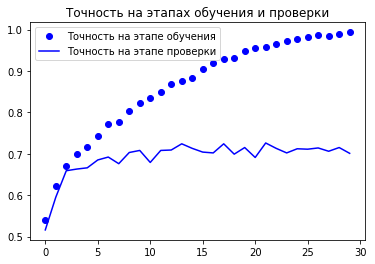

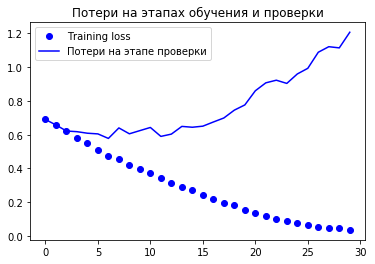

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Точность на этапе обучения')
plt.plot(epochs, val_acc, 'b', label='Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.legend()

plt.show()

На графиках четко наблюдается эффект переобучения. Точность на обучающих
данных линейно растет и приближается к 100 %, тогда как точность на проверочных
данных останавливается на отметке 70–72 %. Потери на этапе проверки достигают
минимума всего после пяти эпох и затем замирают, а потери на этапе обучения
продолжают линейно уменьшаться, почти достигая 0.
Поскольку у нас относительно немного обучающих образцов (2000), переобу-
чение становится проблемой номер один. Вы уже знаете несколько методов, по-
могающих смягчить эту проблему, таких как прореживание и сокращение весов
(L2-регуляризация). Теперь мы познакомимся с еще одним способом, характерным
для распознавания образов и используемым почти повсеместно при обработке
изображений с применением моделей глубокого обучения: способом *расширения
данных* (data augmentation).


## Расширение данных
Причиной переобучения является недостаточное количество образцов для обучения модели, способной обобщать новые данные. Имея бесконечный объем
данных, можно было бы получить модель, учитывающую все аспекты распределения данных: эффект переобучения никогда не наступил бы. Прием расширения данных реализует подход создания дополнительных обучающих данных
из имеющихся путем трансформации образцов множеством случайных преобразований, дающих правдоподобные изображения. Цель состоит в том, чтобы на
этапе обучения модель никогда не увидела одно и то же изображение дважды.
Это поможет модели выявить больше особенностей данных и достичь лучшей
степени обобщения.
Сделать это в Keras можно путем настройки ряда случайных преобразований для
изображений, читаемых экземпляром `ImageDataGenerator`. Начнем с простого
примера.


In [18]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Здесь представлена лишь часть возможных вариантов (полный список вы
найдете в документации к фреймворку Keras). Давайте быстро пробежимся по
этому коду:
* `rotation_range` — величина в градусах (0–180), диапазон, в котором будет осу-
ществляться случайный поворот изображения;
* `width_shift и height_shift` — диапазоны (в долях ширины и высоты), в преде-
лах которых изображения смещаются по горизонтали и вертикали соответ-
ственно;
* `shear_range` — для случайного применения сдвигового (shearing) преобразо-
вания;
* `zoom_range` — для случайного изменения масштаба внутри изображений;
* `horizontal_flip` — для случайного переворачивания половины изображения по
горизонтали — подходит в случае отсутствия предположений о горизонтальной
асимметрии (например, в изображениях реального мира);
* `fill_mode` — стратегия заполнения вновь созданных пикселов, появляющихся
после поворота или смещения по горизонтали/вертикали.
Взгляните на дополнительные изображения.


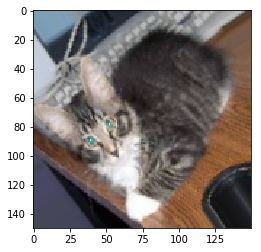

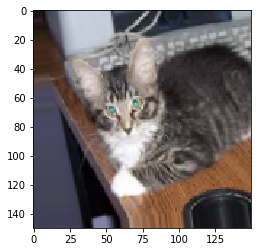

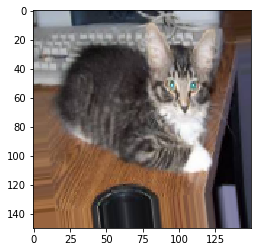

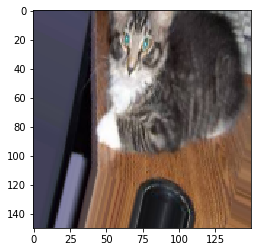

In [19]:
# Модуль с утилитами для обработки изображений

from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

#Выбор одного изображения для расширения

img_path = fnames[3]

# Чтение изображения и изменение его размеров
img = image.load_img(img_path, target_size=(150, 150))

# Преобразование в массив Numpy с формой (150, 150, 3)
x = image.img_to_array(img)

# Изменение формы на (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# Генерация пакетов случайно преобразованных изображений.
# Цикл выполняется бесконечно, поэтому его нужно принудительно прервать в какой-то момент!

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

Если обучить новую сеть с использованием этих настроек расширения данных, она
никогда не увидит одно и то же изображение дважды. Однако входные данные попрежнему будут тесно связаны между собой, потому что получены из небольшого
количества оригинальных изображений, — у вас не получится сгенерировать новую информацию, вы можете только повторить существующую. Поэтому данного
решения недостаточно, чтобы избавиться от эффекта переобучения. Продолжая
борьбу с ним, добавим в модель слой Dropout непосредственно перед полносвязным
классификатором.

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

W0228 10:59:56.998274 140519098640128 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/layers/core.py:144: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Обучим сеть, задействовав расширение данных и прореживание.

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Обратите внимание, что проверочные данные не требуется расширять!

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Целевой каталог
        train_dir,
        # Приведение всех изображений к размеру 150 × 150
        target_size=(150, 150),
        batch_size=32,
        # Так как используется функция потерь binary_crossentropy, метки должны быть бинарными
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100==============================] - 27s 270ms/step - loss: 0.6923 - acc: 0.5151 - val_loss: 0.6780 - val_acc: 0.5819
Epoch 2/100
100/100==============================] - 25s 245ms/step - loss: 0.6799 - acc: 0.5603 - val_loss: 0.6961 - val_acc: 0.5159
Epoch 3/100
100/100==============================] - 25s 247ms/step - loss: 0.6636 - acc: 0.5920 - val_loss: 0.6371 - val_acc: 0.6294
Epoch 4/100
100/100==============================] - 25s 247ms/step - loss: 0.6464 - acc: 0.6206 - val_loss: 0.6144 - val_acc: 0.6624
Epoch 5/100
100/100==============================] - 25s 247ms/step - loss: 0.6185 - acc: 0.6604 - val_loss: 0.6370 - val_acc: 0.6263
Epoch 6/100
100/100==============================] - 26s 260ms/step - loss: 0.6125 - acc: 0.6484 - val_loss: 0.6346 - val_acc: 0.6313
Epoch 7/100
100/100==============================] - 25s 246ms/step - loss: 0.5914 - acc: 0.6768 - val_loss: 0.5

А теперь сохраним модель — мы будем использовать ее позже.

In [22]:
model.save('cats_and_dogs_small_2.h5')

И снова выведем графики с результатами.

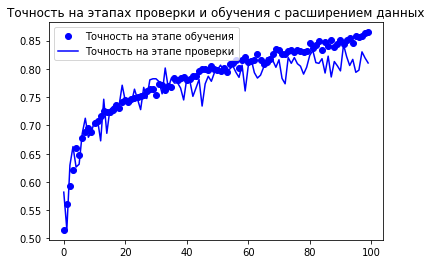

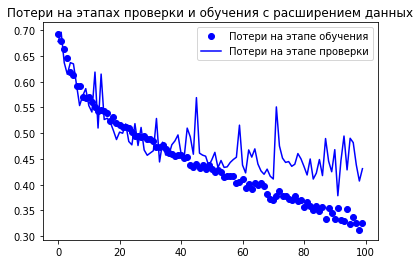

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Точность на этапе обучения')
plt.plot(epochs, val_acc, 'b', label='Точность на этапе проверки')
plt.title('Точность на этапах проверки и обучения с расширением данных')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'b', label='Потери на этапе проверки')
plt.title('Потери на этапах проверки и обучения с расширением данных')
plt.legend()

plt.show()

Применив расширение данных и прореживание, мы практически избавились от переобучения: кривые
точности и потерь на этапе обучения близки к аналогичным кривым на этапе проверки. Теперь мы достигли точности 82 %, улучшив ее на 15 %, в сравнении с не регуляризованной моделью.

Использовав дополнительные методы регуляризации и настроив параметры сети
(например, число фильтров на сверточный слой или число слоев в сети), можно добиться еще более высокой точности, примерно 86 % или 87 %. Однако будет очень трудно подняться выше этой отметки, обучая сверточную нейронную сеть с нуля, потому что у нас слишком мало данных. Следующий шаг к увеличению точности решения этой задачи заключается в использовании предварительно обученной модели, но об этом мы поговорим на практике.
